In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/hdd/aouadt/these/projets/3d_segm


In [20]:
from importlib import reload
import itertools
import random
from functools import reduce
from os.path import join
from time import time
import pathlib
import os
import re
from IPython.display import display


from tqdm import tqdm
import pandas as pd
import cv2
import numpy as np
import matplotlib
# Set global parameters to ensure a white background for all plots
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import pytorch_lightning as pl
import skimage.morphology as morp
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from PIL import Image, ImageDraw
import torchviz
# from deep_morpho.datasets.mnist_dataset import MnistClassifDataset
# from deep_morpho.models import LightningBiMoNNClassifier, BiSE, COBiSE, BiSEC, COBiSEC
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['axes.facecolor'] = 'white'


import deep_morpho.models.softplus as sfp
import general.array_morphology as arm
import general.structuring_elements as selm
from general.nn.loss import DiceLoss
import deep_morpho.threshold_fn as threshold_fn
import deep_morpho.morp_operations as morpop
import deep_morpho.models.threshold_layer as threshold_layer
import deep_morpho.models.complementation_layer as complementation_layer
import deep_morpho.models.pconv as pconv
import deep_morpho.models.lightning_pconv as lpconv
import deep_morpho.models.bise as bise
import deep_morpho.models.lui as lui
import deep_morpho.models.bisel as bisel
# import deep_morpho.models.cobise as cobise
import deep_morpho.models.dilation_sum_layer as dis
import deep_morpho.models.bimonn as bimonn
import deep_morpho.models as models
# import deep_morpho.models.lightning_bise as lbise
# import deep_morpho.models.lightning_cobise as lcobise
import deep_morpho.models.lightning_bimonn as lbimonn
import deep_morpho.datasets.generate_forms1 as gfo
import deep_morpho.datasets.generate_forms2 as gfo2
import deep_morpho.datasets.generate_forms3 as gfo3
import deep_morpho.datasets.axspa_roi_dataset as axd
import deep_morpho.datasets.diskorect_dataset as mrda
import deep_morpho.datasets.mnist_dataset as mnist_dataset
import deep_morpho.observables.plot_parameters as obs_weights
import deep_morpho.observables.plot_pred as obs_pred
import deep_morpho.observables.weight_histogram as weight_histogram
import deep_morpho.observables as obs
import general.nn.viz.plot_histogram as phist
import general.nn.viz.element_image as eltimage
import general.nn.viz.element_histogram as elthistogram
import deep_morpho.viz.morp_operations_viz as mov
import deep_morpho.viz.elt_generator_bimonn_forward_save as eltgenbifor
import deep_morpho.viz.elt_generator_bimonn_histogram as eltgenbihist
import deep_morpho.viz.bimonn_viz as bimonn_viz
import deep_morpho.save_results_template.load_args as largs
import deep_morpho.save_results_template.display_results as dr


def reload_modules():
    for modl in [sfp, arm, selm, threshold_fn, morpop,
                 threshold_layer,complementation_layer, pconv, lpconv, bise, lui, bisel, 
                #  cobise,
                 dis, bimonn, models, 
                #  lbise, 
                 lbimonn, 
                #  lcobise, 
                 gfo, gfo2, gfo3, axd,
                 mrda, mnist_dataset, obs_weights, obs_pred, obs,
                weight_histogram, phist, eltimage, elthistogram, mov, eltgenbifor, eltgenbihist, bimonn_viz, largs, dr]:
        reload(modl)
        
reload_modules()

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

cuda


# Individual Experiments

In [ ]:
reload_modules()
# tb_path = ("deep_morpho/results/DGMM_2022/sandbox/1/axspa_roi/version_7")
# tb_path = "/hdd/aouadt/these/projets/3d_segm/deep_morpho/results/results_tensorboards/Bimonn_exp_56/sandbox/2/softplus/diskorect/opening/disk/version_1"
# tb_path = "deep_morpho/results/results_tensorboards/Bimonn_exp_59/sandbox/0/softplus/diskorect/translation_erosion/hstick/version_0"
tb_path = "deep_morpho/results/results_tensorboards/Bimonn_exp_59/sandbox/0/softplus/diskorect/translation_erosion/dcross/version_0"

tb_path = join(tb_path, 'checkpoints', os.listdir(join(tb_path, 'checkpoints'))[0])

model = models.LightningBiMoNN.load_from_checkpoint(tb_path)
model.to(device)

loss = nn.BCELoss()

# Multi Experiments comparison Bise

In [4]:
def list_dir_joined(folder: str):
    return [os.path.join(folder, k) for k in os.listdir(folder)]

# path_global = "deep_morpho/results/results_tensorboards/Bimonn_mega_multi_1/softplus/diskorect/"
# all_paths = []
# for operation in os.listdir(path_global):
#     if os.path.isdir(join(path_global, operation)):
#         for selem in os.listdir(join(path_global, operation)):
#             all_paths += sorted(list_dir_joined(join(path_global, operation, selem)), key=lambda x: int(
#                 re.findall(r'version_(\d+)$', x)[0]
#             ))[:-1]

In [5]:
def get_tb_paths(model, dataset):
    path_global = f"deep_morpho/results/results_tensorboards/Bimonn_exp_75/multi/0/{model}/softplus/{dataset}/"
    all_paths = []
    for operation in os.listdir(path_global):
        if not os.path.isdir(join(path_global, operation)):
            continue
        for selem in os.listdir(join(path_global, operation)):
            all_paths += sorted(list_dir_joined(join(path_global, operation, selem)), key=lambda x: int(
                re.findall(r'version_(\d+)$', x)[0]
            ))
    return all_paths

In [6]:
models_type = [
    'bisel',
    'dual_bisel'
]
datasets = [
    'diskorect',
    'mnist',
    'inverted_mnist',
    'mnist_gray',
    'fashionmnist'
]

all_paths = []
for model in models_type:
    for dataset in datasets:
        all_paths += get_tb_paths(model, dataset)

big_df, _, _ = dr.DisplayResults().get_df_from_tb_paths(all_paths, show_details=False)

Reading results:  33%|███▎      | 3361/10085 [00:21<00:45, 147.23it/s]2024-03-05 11:43:10.496868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hdd/python_venvs/torchenv/lib/python3.8/site-packages/cv2/../../lib:/usr/local/cuda-10.1/lib64:
2024-03-05 11:43:10.496889: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Args: 100%|██████████| 46/46 [00:00<00:00, 597.73it/s]


In [8]:
big_df1, _, _ = dr.DisplayResults().get_df_from_tb_paths([
    "deep_morpho/results/results_tensorboards/Bimonn_exp_75/multi/0/dual_bisel/softplus/diskorect/erosion/bcomplex/version_0"
], show_details=False)
big_df1["selem"]

Args:   0%|          | 0/46 [00:00<?, ?it/s]

Args: 100%|██████████| 46/46 [00:00<00:00, 395364.72it/s]


0    bcomplex
Name: selem, dtype: object

In [113]:
big_df2, _, _ = dr.DisplayResults().get_df_from_tb_paths([
    "deep_morpho/results/results_tensorboards/Bimonn_exp_75/sandbox/3_/0/diskorect/bimonn/erosion/bcomplex/version_0"
], show_details=False)
big_df2["dice"] = big_df2["train_dice"]
big_df2["binary_mode_dice"] = big_df2["binary_mode_train_dice"]
big_df2["dataset_type"] = big_df2["dataset"].apply(lambda x: x.replace("dataset", ""))
big_df2["atomic_element"] = big_df2["atomic_element.net"]

Reading results:   0%|          | 0/1 [00:00<?, ?it/s]/hdd/aouadt/these/projets/3d_segm/deep_morpho/save_results_template/load_args.py:95: UserWarning: More than one match for \n?   loss_data[^\n]+\.(\w+)\n in ['BCELoss', 'BCELoss']
  # assert len(exps) == 1, exps
Args: 100%|██████████| 46/46 [00:00<00:00, 246094.37it/s]


In [108]:
big_df2[big_df2["operation"].isna()]["name"]

0    erosion/bcomplex
Name: name, dtype: object

In [111]:
df.loc[df["operation"].isna(), "operation"] = df.loc[df["operation"].isna(), "name"].apply(lambda x: x.split("/")[0])


In [115]:
big_df2["selem"]

0    bcomplex
Name: selem, dtype: object

In [52]:
big_df2

,args,tb_path,weights,normalized_weights,bias,dice,baseline_dice,binary_mode_dice,convergence_dice,activation_P,...,loss_data_str,binary_params,float_params,n_values,normalize.datamodule,initializer_method,initializer_args,bise_init_method,operation,selem
0,"{'optimizer': 'Adam', 'loss_data': 'BCELoss', ...",deep_morpho/results/results_tensorboards/Bimon...,None,{},[None],0.6104325020313263,0.3990153,-1.0,None,None,...,BCELoss,54,54,1,None,None,None,CUSTOM_CONSTANT_DUAL_RANDOM_BIAS,None,None


In [7]:
import os
total_renamed = 0
for tb_path in tqdm(big_df[big_df['bise_init_method'] == "CUSTOM_CONSTANT_RANDOM_BIAS"].tb_path):
    if not os.path.exists(tb_path):
        continue
    new_path = tb_path.replace("0/dual_bisel", "1/dual_bisel")
    pathlib.Path(new_path).parent.mkdir(exist_ok=True, parents=True)
    os.rename(tb_path, new_path)
    total_renamed += 1

print(total_renamed)

100%|██████████| 5125/5125 [00:00<00:00, 49036.88it/s]

5125


In [10]:
import os
total_renamed = 0
for tb_path in tqdm(big_df[big_df['experiment_name'] == "Bimonn_exp_75/multi/1"].tb_path):
    if not os.path.exists(tb_path):
        continue
    args_path = join(tb_path, "args.yaml")
    with open(args_path, "r") as f:
        args_content = f.read()
    with open(args_path, "w") as f:
        print(args_content.replace('Bimonn_exp_75/multi/1', 'Bimonn_exp_75/multi/0'), file=f)
    # new_path = tb_path.replace("0/dual_bisel", "1/dual_bisel")
    # pathlib.Path(new_path).parent.mkdir(exist_ok=True, parents=True)
    # os.rename(tb_path, new_path)
    total_renamed += 1

print(total_renamed)

0it [00:00, ?it/s]

0


In [126]:
from deep_morpho.models import BiseBiasOptimEnum, ClosestSelemDistanceEnum, ClosestSelemEnum, InitBiseEnum, InitBimonnEnum
all_keys_line = [
    "experiment_name",
    "experiment_subname",
    "name",
    "dataset_type",
    "dataset_path",
    "n_inputs",
    "learning_rate",
    "batch_size",
    "num_workers",
    "freq_imgs",
    "n_epochs",
    "n_atoms",
    "atomic_element",
    "kernel_size",
    "init_weight_mode",
    "constant_activation_P",
    "constant_weight_P",
    "threshold_mode",
    "alpha_init",
    "share_weights",
    "loss",
    "patience_loss",
    "patience_reduce_lr",
    "init_weight_mode",
    "closest_selem_method",
    "closest_selem_distance_fn",
    "bias_optim_mode",
    "loss_data_str",
]
bise_keys = ["init_weight_mode", "initializer_method", "initializer_args", "closest_selem_method", "closest_selem_distance_fn", "bias_optim_mode"]
bise_str_keys = ['bias_optim_mode', 'closest_selem_method', 'initializer_method',]
key_to_enum = {
    'closest_selem_method': ClosestSelemEnum,
    'closest_selem_distance_fn': ClosestSelemDistanceEnum,
    'bias_optim_mode': BiseBiasOptimEnum,
    'init_weight_mode': InitBiseEnum,
    'initializer_method': InitBimonnEnum,
    'bise_init_method': InitBiseEnum,
}

In [57]:
key_to_enum[key]

<enum 'InitBimonnEnum'>

In [58]:
key_to_enum[key][row_template[key]]

<InitBimonnEnum.INPUT_MEAN: 2>

In [118]:
# key = all_keys_line[4]
print(key)
yaml_str = new_str
print(load_args.regex_find_or_none(rf"( |^|\n){key}: ([^\n]+)\n", yaml_str, ))
print(load_args.regex_find_or_none(rf"[ ^\n]{key}: [^\n]+\n", yaml_str, ))

initializer_method
('\n', '!!python/object/apply:deep_morpho.initializer.bimonn_initializer.InitBimonnEnum')

initializer_method: !!python/object/apply:deep_morpho.initializer.bimonn_initializer.InitBimonnEnum



In [112]:
load_args.regex_find_or_none(r"( |^)(bana)", "banana")

('', 'bana')

In [124]:
print(key)
load_args.regex_find_or_none(rf"\n?{key}[^\n]+\n- {template_value}\n", new_str)

bise_init_method


In [127]:
import deep_morpho.save_results_template.load_args as load_args
row_template = big_df[big_df['experiment_name'] == "Bimonn_exp_75/multi/1"].iloc[0]
args_yaml_template_path = join(row_template.tb_path, "args.yaml")
with open(args_yaml_template_path, "r") as f:
    template_yaml = f.read()
for row_idx, row in big_df[big_df['experiment_name'] == "Bimonn_exp_75/multi/0"].iterrows():
    new_str = template_yaml

    new_str = new_str.replace(row_template["loss_data_str"], row["loss_data_str"])

    key = "activation_P"
    if row[key] is not None:
        template_str = load_args.regex_find_or_none(f"^{key}: [^\n]+\n", new_str, )
        row_str = template_str.replace(row_template[key], row[key])
        new_str = new_str.replace(template_str, row_str)

    for key in all_keys_line:
        if row[key] is not None:
            template_str = load_args.regex_find_or_none(f"[ ^\n]{key}: [^\n]+\n", new_str, )
            row_str = template_str.replace(row_template[key], row[key])
            new_str = new_str.replace(template_str, row_str)
            # print(row_template[key], row[key])
    
    key = "bise_init_method"

    template_value = key_to_enum[key][row_template[key]].value
    template_str = load_args.regex_find_or_none(rf"\n?\t?bise_init_method[^\n]+\n +- {template_value}", new_str)

    row_value = key_to_enum[key][row[key]].value
    row_str = template_str.replace(str(template_value), str(row_value))
    
    new_str = new_str.replace(template_str, row_str)


    for key in bise_keys:
        if row[key] is not None:
            template_value = key_to_enum[key][row_template[key]].value
            template_str = load_args.regex_find_or_none(rf"\n?{key}[^\n]+\n- {template_value}\n", new_str)

            row_value = key_to_enum[key][row[key]].value
            row_str = template_str.replace(str(template_value), str(row_value))
            
            new_str = new_str.replace(template_str, row_str)


    for key in bise_str_keys:
        if row[key] is not None:
            new_str = new_str.replace(row_template[key], row[key])

    try:
        with open(join(row['tb_path'], 'args.yaml'), "w") as f:
            print(new_str, file=f)
    except FileNotFoundError:
        with open(join(row['tb_path'], 'args.yaml').replace("0/dual_bisel", "1/dual_bisel"), "w") as f:
            print(new_str, file=f)
    # assert False

In [8]:
def stylize_df(df):
    return df.style.background_gradient(cmap='RdBu', vmin=0, vmax=1).format('{:.2f}')

def show_all_df_color(df, dataset: str, atomic_element: str, metric_mode: str):
    cur_df = df[(df["dataset_type"] == dataset) & (df["atomic_element"] == atomic_element)]

    new_cols = {'dcross': 'dc', 'disk': 'di', 'hstick': 'hs', 'bcomplex': 'bc', 'bdiamond': 'bd', 'bsquare': 'bs', 'scross': 'sc'}
    changing = ["bias_optim_mode", "loss_data_str", "learning_rate"]
    df_all = cur_df.pivot_table(
        index=changing, columns=['operation', 'selem'], values=[metric_mode], aggfunc='mean'
    ).rename(columns=new_cols)
    return stylize_df(df_all), df_all

In [95]:
dataset = "diskorect"
atomic_element = "dual_bisel"
cur_df = big_df2[(big_df2["dataset_type"] == dataset) & (big_df2["atomic_element"] == atomic_element)]
big_df2["operation"]


0    None
Name: operation, dtype: object

In [116]:
style2, df2 = show_all_df_color(big_df2, "diskorect", "dual_bisel", "dice")
style2

,,,dice
,,operation,erosion
,,selem,bc
bias_optim_mode,loss_data_str,learning_rate,
POSITIVE_INTERVAL_PROJECTED,BCELoss,0.1,0.61


In [82]:
def draw_boxplot(df, title=None, target='dice', fontsize=12):
    cdict = {
        "dilation": "blue", "erosion": "red", "opening": "orange", "closing": "green", "white_tophat": "lyme", 
        "black_tophat": "darksalmon"
    }
    display_text = {
        "dilation": "$\oplus$", "erosion": "$\ominus$", "opening": "$\circ$", "closing": r"$\bullet$",
    }

    for key, value in list(cdict.items()):
        cdict[key + "_gray"] = value

    # plt.figure()
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    box = df.boxplot(
            column=target,
            by=['operation', 'selem'],
            rot=45,
            ax=ax,
            return_type="both",
            patch_artist=True,
            fontsize=fontsize,
        )

    colors = []
    new_labels = []
    for xtick in box[target].ax.get_xticklabels():
        text = xtick.get_text()
        op = text[1:-1].split(',')[0]
        colors.append(cdict[op])
        xtick.set_color(cdict[op])
        # in text, replace the operation by the corresponding symbol
        for key, value in display_text.items():
            text = text.replace(key, value)
        new_labels.append(text)

    for patch, flier,color in zip(box[target].lines['boxes'], box[target].lines['fliers'], colors):
        patch.set_facecolor(color)
        # patch.set_color(color)
        flier.set_markeredgecolor(color)
        patch.set_alpha(.4)

    # ax.set_xticklabels(ax.get_xticklabels(), ha="right")
    ax.set_xticklabels(new_labels, ha="right")
    ax.set_xlabel(None)
    ax.set_title(None)
    if title is not None:
        fig.suptitle(title, fontsize=fontsize)
    return fig

In [43]:
big_df[
    (big_df["dataset_type"] == "diskorect") &
    (big_df["atomic_element"] == "dual_bisel") &
    (big_df["operation"] == "erosion") &
    (big_df["selem"] == "bcomplex") &
    (big_df["loss_data_str"] == "BCELoss") &
    (big_df["bias_optim_mode"] == "POSITIVE_INTERVAL_PROJECTED") &
    (big_df["learning_rate"] == "0.1")
].tb_path.iloc[0]

'deep_morpho/results/results_tensorboards/Bimonn_exp_75/multi/0/dual_bisel/softplus/diskorect/erosion/bcomplex/version_15'

In [137]:
(
    5 *  # dataset
    6 *  # operations
    7 *  # selems
    3 *  # loss
    2 *  # learning rate
    2    # atomic element
)

2520

In [129]:
big_df.loc[
    (big_df["atomic_element"] == "bisel") &
    (big_df["batch_size"] == "256"),
    "dataset_type"
].unique()

array(['diskorect', 'mnist', 'inverted_mnist'], dtype=object)

In [31]:
to_compute = []
big_df.loc[(
    (big_df["binary_mode_dice"].isna()) &
    (big_df["dataset_type"] == "diskorect") &
    (np.isin(big_df["operation"], ["dilation", "erosion", "opening", "closing"])) &
    (big_df["bias_optim_mode"] != "POSITIVE_INTERVAL_PROJECTED")
), [
    "dataset_type",
    "atomic_element",
    "bias_optim_mode",
    "loss_data_str",
    "learning_rate",
    "operation",
    "selem"
]]

# random.shuffle(to_compute)
# eights = [to_compute[i::8] for i in range(8)]


# with open("deep_morpho/saved_args/sandbox/args_good.txt", "w") as f:
#     print(*to_compute, file=f, sep="\n")

# for i, batch in enumerate(eights):
#     with open(f"deep_morpho/saved_args/sandbox/args_good_{i}.txt", "w") as f:
#         print(*batch, file=f, sep="\n")


,dataset_type,atomic_element,bias_optim_mode,loss_data_str,learning_rate,operation,selem


In [25]:
to_compute = []
for line in big_df.loc[(
    (big_df["binary_mode_dice"] < 0.9) &
    (big_df["dataset_type"] == "diskorect") &
    (np.isin(big_df["operation"], ["dilation", "erosion", "opening", "closing"])) &
    (big_df["bias_optim_mode"] != "POSITIVE_INTERVAL_PROJECTED")
), [
    "dataset_type",
    "atomic_element",
    "bias_optim_mode",
    "loss_data_str",
    "learning_rate",
    "operation",
    "selem"
]].values:
    to_compute.append(tuple(line))

random.shuffle(to_compute)
eights = [to_compute[i::8] for i in range(8)]


with open("deep_morpho/saved_args/sandbox/args_good.txt", "w") as f:
    print(*to_compute, file=f, sep="\n")

for i, batch in enumerate(eights):
    with open(f"deep_morpho/saved_args/sandbox/args_good_{i}.txt", "w") as f:
        print(*batch, file=f, sep="\n")


In [30]:
# generate saved args for recompute failed based on what's above
path = pathlib.Path("deep_morpho/saved_args/recompute_failed")
with open(path / "args_0.py", "r") as f:
    args_0 = f.read()

for k in range(1, 8):
    with open(path / f"args_{k}.py", "w") as f:
        f.write(args_0.replace("deep_morpho/saved_args/sandbox/args_good_0.txt", f"deep_morpho/saved_args/sandbox/args_good_{k}.txt"))


In [75]:
big_df.loc[
    big_df["tb_path"] =="deep_morpho/results/results_tensorboards/Bimonn_exp_75/multi/0/bisel/softplus/diskorect/erosion/disk/version_34",
    ["loss_data_str", "bias_optim_mode", "learning_rate",]
]

,loss_data_str,bias_optim_mode,learning_rate
809,DiceLoss,POSITIVE_INTERVAL_PROJECTED,0.1


In [11]:
dataset = (
    "diskorect"
    # "mnist"
    # "inverted_mnist"
    # "mnist_gray"
    # "fashionmnist"
)
atomic_element = (
    # "bisel"
    "dual_bisel"
)
metric_mode = (
    # "binary_mode_dice"
    "dice"
)
cur_df = big_df[
    (np.isin(big_df["operation"], ["erosion", "dilation"])) &
    (big_df["bias_optim_mode"] != "POSITIVE_INTERVAL_PROJECTED")
]



print(f"{dataset} {atomic_element}, {metric_mode}")




df_style, df = show_all_df_color(cur_df, dataset, atomic_element, metric_mode)
df_style

diskorect dual_bisel, dice


bisel - diskorect - dice


operation  selem   
dilation   bcomplex    18
           bdiamond    18
           bsquare     18
           dcross      18
           disk        18
           hstick      18
           scross      18
erosion    bcomplex    16
           bdiamond    15
           bsquare     18
           dcross      16
           disk        13
           hstick      18
           scross      18
dtype: int64

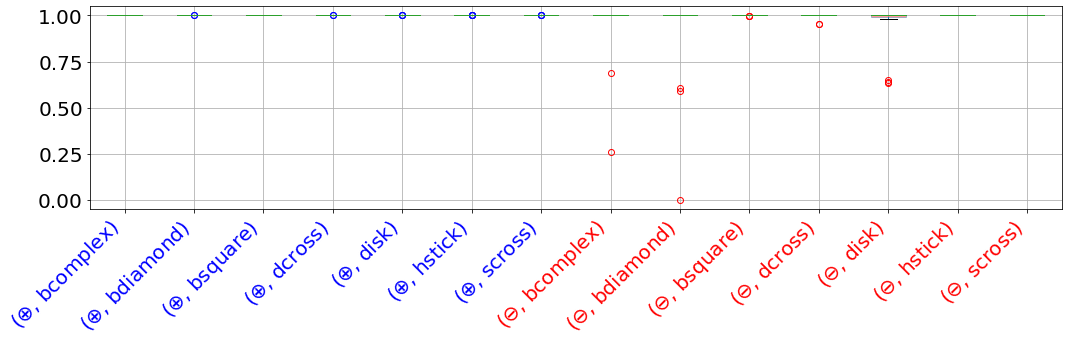

In [73]:
# ERODILA
model = (
    "bisel"
    # "dual_bisel"
)
dataset = "diskorect"
target = (
    "dice"
    # "binary_mode_dice"
)
print(f"{model} - {dataset} - {target}")

cur_df = big_df[
    (big_df["atomic_element"] == model) & 
    (big_df["dataset_type"] == dataset) &
    (big_df["bias_optim_mode"] != "POSITIVE_INTERVAL_PROJECTED") &
    (np.isin(big_df["operation"], ["dilation", "erosion",]))
]

display(
    cur_df.groupby(["operation", "selem"]).apply(lambda x: (x[target] > 0.99).sum())
    # cur_df.groupby(["operation", "selem"]).apply(lambda x: x[target].max())
)


fig = draw_boxplot(
    cur_df, 
    # title=f"{model} - {dataset}",
    title="",
    target=target,
    fontsize=20
)
fig.tight_layout()
# fig.savefig(f"figures_for_manuscript/{model}_{dataset}_{target}_erodila.png")
# plt.savefig("test.png", bbox_inches='tight')

In [107]:
# df_all = cur_df.pivot_table(
#         index=changing, columns=['operation', 'selem'], values=[metric_mode], aggfunc='mean'
#     ).rename(columns=new_cols)

new_columns = [
    ('dice', 'bisel'),
    ('binary_mode_dice', 'bisel'),
    ('dice', 'dual_bisel'),
    ('binary_mode_dice', 'dual_bisel')
]

pivot_df = big_df[
    # (big_df["atomic_element"] == "bisel") &
    (big_df["dataset_type"] == dataset) &
    (big_df["bias_optim_mode"] != "POSITIVE_INTERVAL_PROJECTED") &
    (np.isin(big_df["operation"], ["opening", "closing",]))
].pivot_table(
    index=["operation", "selem"], columns=["atomic_element"], values=["dice", "binary_mode_dice"], aggfunc=lambda x: (x > 0.99).sum()
)
display(pivot_df)
pivot_df = pivot_df.reindex(columns=new_columns)
display(pivot_df)
# pivot_df.to_csv("figures_for_manuscript/diskorect-opeclos.csv")

binary_mode_dice             dice           
atomic_element                bisel dual_bisel bisel dual_bisel
operation selem                                                
closing   bcomplex                6          1     6          1
          bdiamond                2          0     4          0
          bsquare                 2          0    17          9
          dcross                 15          9    15          9
          disk                    2          2     5          2
          hstick                 11         15    14         18
          scross                  7          0     7          0
opening   bcomplex                7          3     9          3
          bdiamond                1          1     1          1
          bsquare                 0          0    12          8
          dcross                 13          8    11          7
          disk                    3          2     3          2
          hstick                  7         16     8         18
          scross                  5          1     4          1

dice binary_mode_dice       dice binary_mode_dice
atomic_element     bisel            bisel dual_bisel       dual_bisel
operation selem                                                      
closing   bcomplex     6                6          1                1
          bdiamond     4                2          0                0
          bsquare     17                2          9                0
          dcross      15               15          9                9
          disk         5                2          2                2
          hstick      14               11         18               15
          scross       7                7          0                0
opening   bcomplex     9                7          3                3
          bdiamond     1                1          1                1
          bsquare     12                0          8                0
          dcross      11               13          7                8
          disk         3                3          2                2
          hstick       8                7         18               16
          scross       4                5          1                1

In [ ]:
MultiIndex([
    (            'dice',      'bisel'),
    ('binary_mode_dice',      'bisel'),
    (            'dice', 'dual_bisel')
    ('binary_mode_dice', 'dual_bisel'),
    ],
    names=[None, 'atomic_element'])

bisel - diskorect - dice


operation  selem   
closing    bcomplex     6
           bdiamond     4
           bsquare     17
           dcross      15
           disk         5
           hstick      14
           scross       7
opening    bcomplex     9
           bdiamond     1
           bsquare     12
           dcross      11
           disk         3
           hstick       8
           scross       4
dtype: int64

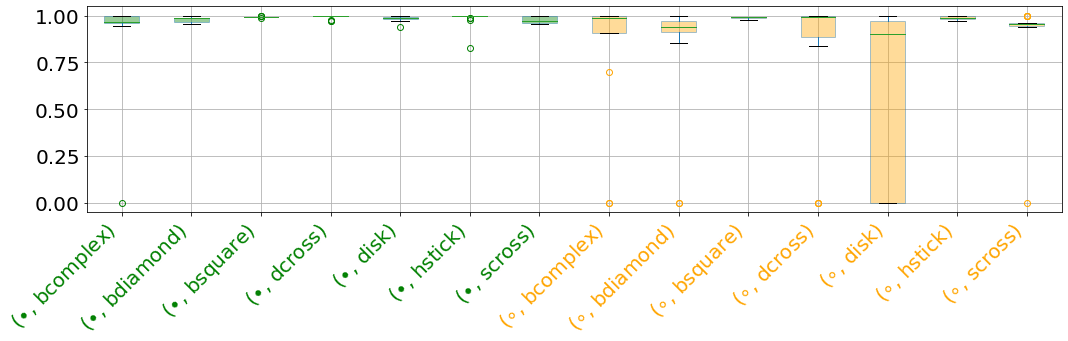

In [88]:
# OPECLOS
model = (
    "bisel"
    # "dual_bisel"
)
dataset = "diskorect"
target = (
    "dice"
    # "binary_mode_dice"
)
print(f"{model} - {dataset} - {target}")

cur_df = big_df[
    (big_df["atomic_element"] == model) & 
    (big_df["dataset_type"] == dataset) &
    (big_df["bias_optim_mode"] != "POSITIVE_INTERVAL_PROJECTED") &
    (np.isin(big_df["operation"], ["opening", "closing",]))
]

display(
    cur_df.groupby(["operation", "selem"]).apply(lambda x: (x[target] > 0.99).sum())
    # cur_df.groupby(["operation", "selem"]).apply(lambda x: x[target].max())
)


fig = draw_boxplot(
    cur_df, 
    # title=f"{model} - {dataset}",
    title="",
    target=target,
    fontsize=20
)
fig.tight_layout()
# fig.savefig(f"figures_for_manuscript/{model}_{dataset}_{target}_opeclos.png")
# plt.savefig("test.png", bbox_inches='tight')

In [41]:
datasets = [
    "diskorect",
    "mnist",
    "inverted_mnist",
    # "mnist_gray",
    # "fashionmnist",
]
atomic_elements = [
    "bisel",
    "dual_bisel"
]
metric_modes = (
    "binary_mode_dice",
)
cur_df = big_df[
    # (np.isin(big_df["operation"], ["erosion", "dilation"])) &
    (big_df["bias_optim_mode"] != "POSITIVE_INTERVAL_PROJECTED")
]

not_computed_args = []

for dataset in datasets:
    for atomic_element in atomic_elements:
        for metric_mode in metric_modes:
            df_style, df = show_all_df_color(cur_df, dataset, atomic_element, metric_mode)

            not_computed_args += (
                [(dataset, atomic_element,) + df.index[i] + df.columns[j] for i, j in zip(*np.where(df.isna()))]
                # [(dataset, atomic_element,) + df.index[i] + df.columns[j] for i, j in zip(*np.where(df == -1))]
            )
print("Not computed args")
print(not_computed_args)
print(len(not_computed_args))


Not computed args
[]
0


In [69]:
import deep_morpho.save_results_template.load_args as load_args
reload(load_args)
load_args.load_args_from_str(new_str)

{'optimizer': 'Adam',
 'loss_data': 'BCELoss',
 'experiment_name': 'Bimonn_exp_75/multi/0',
 'experiment_subname': 'bisel/softplus/diskorect/opening/bsquare',
 'name': 'opening/bsquare',
 'dataset_type': 'diskorect',
 'dataset_path': 'generate',
 'n_inputs': '2560000',
 'learning_rate': '0.01',
 'batch_size': '256',
 'num_workers': '20',
 'freq_imgs': '1000',
 'n_epochs': '1',
 'n_atoms': '2',
 'atomic_element': 'bisel',
 'kernel_size': '7',
 'init_weight_mode': None,
 'activation_P': '0',
 'constant_activation_P': 'false',
 'constant_weight_P': None,
 'threshold_mode': None,
 'alpha_init': None,
 'share_weights': None,
 'loss': None,
 'patience_loss': '2100',
 'patience_reduce_lr': '700',
 'closest_selem_method': 'MIN_DIST_DIST_TO_CST',
 'closest_selem_distance_fn': None,
 'bias_optim_mode': 'RAW',
 'loss_data_str': 'BCELoss',
 'initializer_method': 'INPUT_MEAN',
 'initializer_args': None,
 'bise_init_method': 'CUSTOM_CONSTANT_RANDOM_BIAS'}

In [15]:
def draw_boxplot_per_dataset(df, column, by=["dataset_type", "operation", "selem"], title=''):
    cdict = {
        "diskorect": "cyan", "mnist": "red", "inverted_mnist": "lime", "fashionmnist": "green", "mnist_gray": "darksalmon", 
    }

    # for key, value in list(cdict.items()):
    #     cdict[key + "_gray"] = value

    # plt.figure()
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    box = df.boxplot(
        column=column, by=by, rot=45, ax=ax, return_type="both", patch_artist=True,
    )

    colors = []
    for xtick in box[column].ax.get_xticklabels():
        dataset, operation, selem = xtick.get_text()[1:-1].split(',')
        colors.append(cdict[dataset])
        xtick.set_color(cdict[dataset])

    for patch, flier, color in zip(box[column].lines['boxes'], box[column].lines['fliers'], colors):
        patch.set_facecolor(color)
        # patch.set_color(color)
        flier.set_markeredgecolor(color)
        patch.set_alpha(.4)

    ax.set_xticklabels(ax.get_xticklabels(), ha="right")
    ax.set_xlabel(None)
    fig.suptitle(title)
    fig.tight_layout()

    return fig


white_tophat bisel
white_tophat dual_bisel
black_tophat bisel
black_tophat dual_bisel


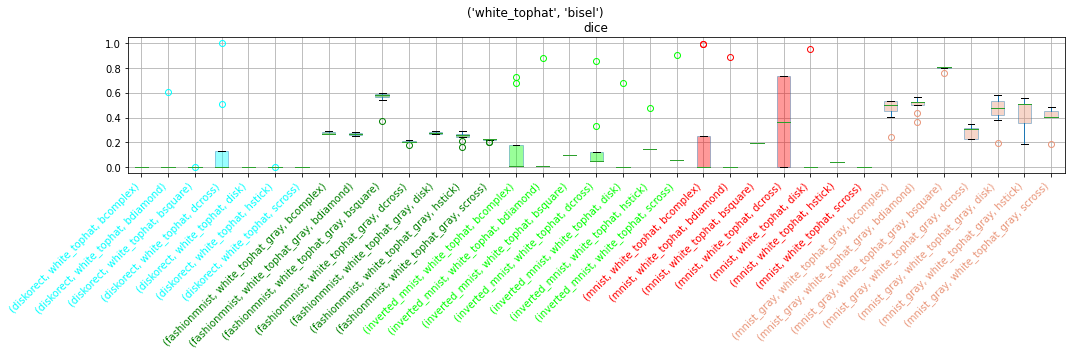

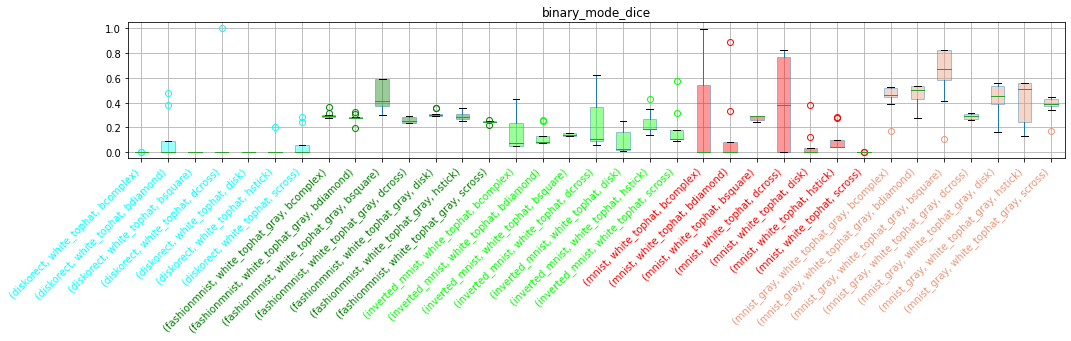

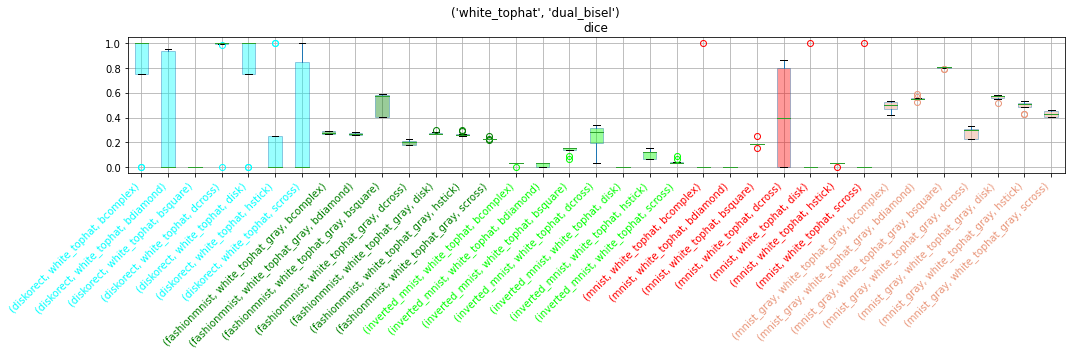

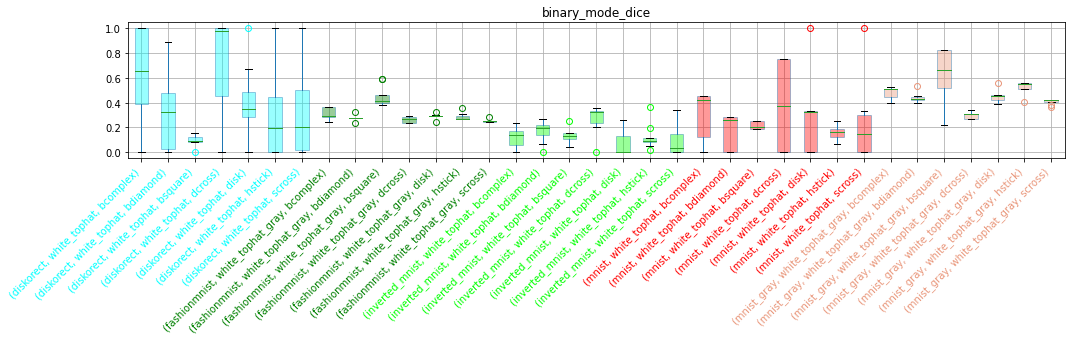

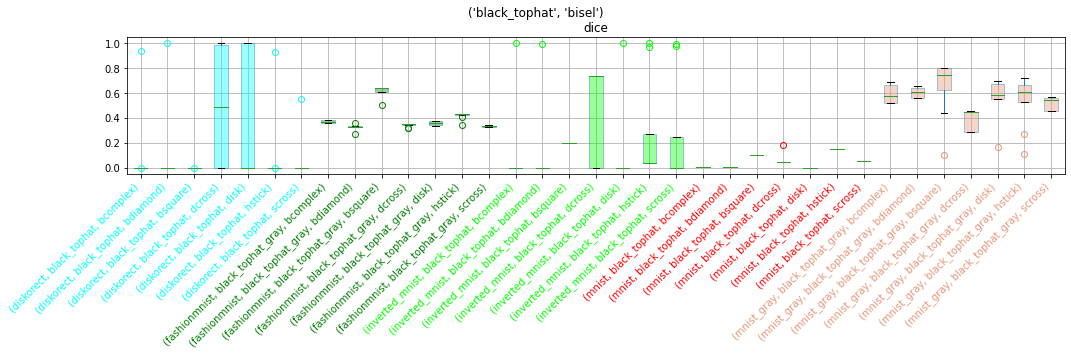

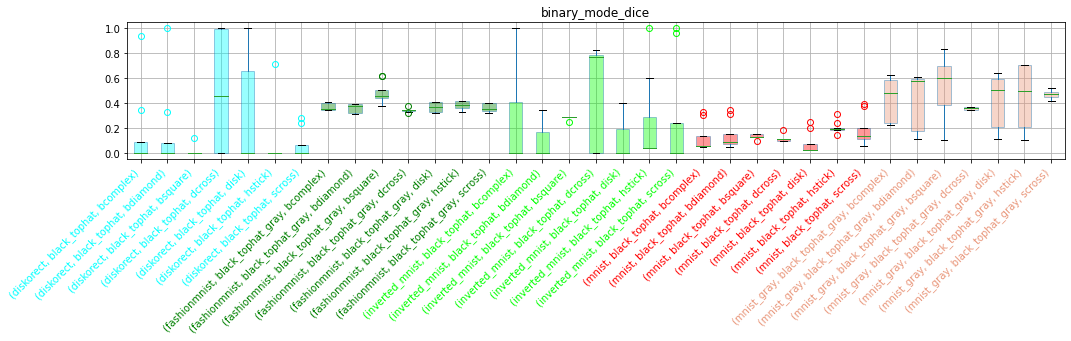

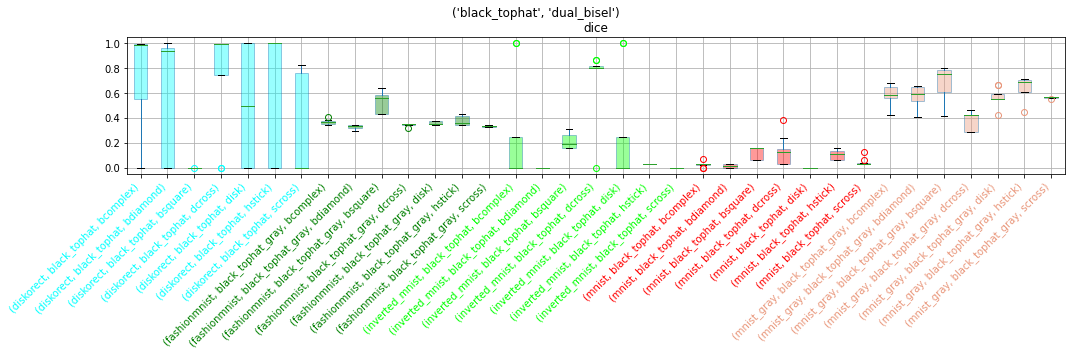

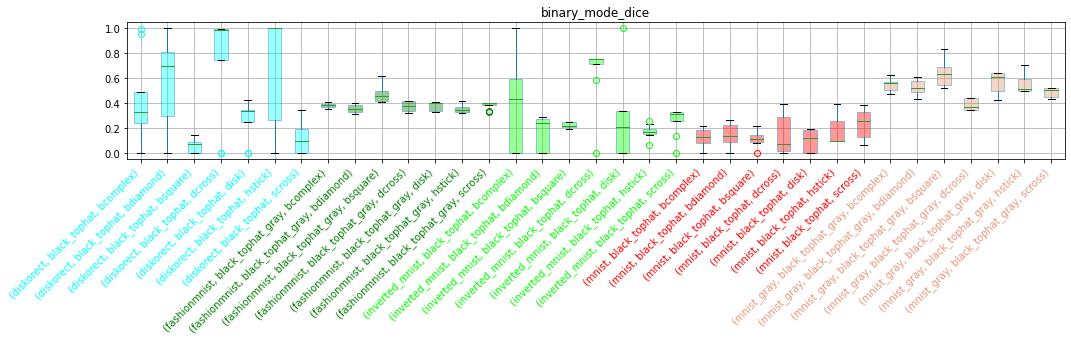

In [19]:

for op in [
    'white_tophat', 'black_tophat',
    # 'opening', 'closing'
    # "dilation", "erosion"
]:
    for model in ['bisel', 'dual_bisel']:
        print(op, model)
# op = "opening"
# model = "dual_bisel"

        idxes = (
            (big_df['atomic_element'] == model) &
            np.isin(big_df['operation'], [f"{op}", f"{op}_gray"]) &
            (big_df['loss_data_str'] == "MSELoss") &
            (big_df['dice'] != -1)
        )

        fig = draw_boxplot_per_dataset(
            big_df[idxes], 
            'dice'
        )
        fig.suptitle((op, model))

        draw_boxplot_per_dataset(
            big_df[idxes], 
            'binary_mode_dice'
        )

In [29]:
np.array([type(x) == str for x in big_df['loss_train']]).sum()

1823

white_tophat bisel
white_tophat dual_bisel


TypeError: unsupported operand type(s) for +: 'float' and 'str'

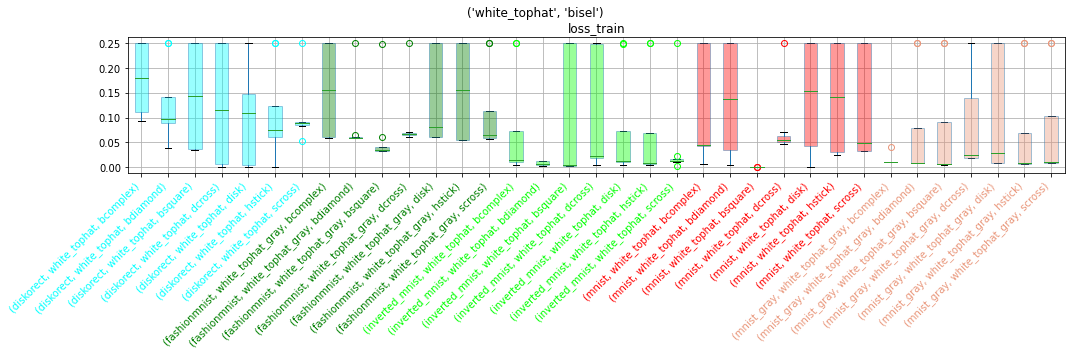

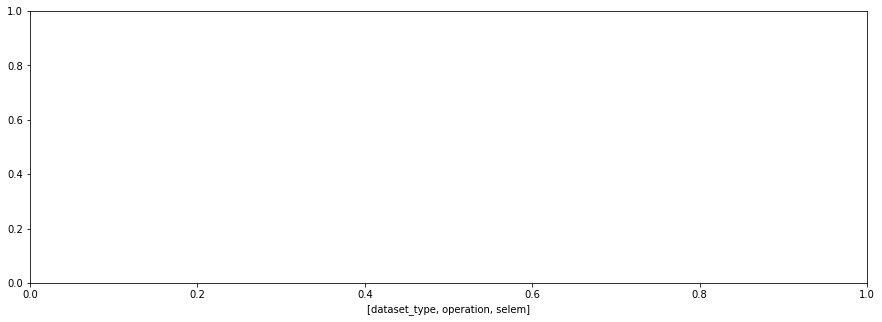

In [27]:

for op in ['white_tophat', 'black_tophat']:
    for model in ['bisel', 'dual_bisel']:
        print(op, model)
# op = "opening"
# model = "dual_bisel"

        idxes = (
            (big_df['atomic_element'] == model) &
            np.isin(big_df['operation'], [f"{op}", f"{op}_gray"]) &
            (big_df['loss_data'] == "MSELoss")
            # (big_df['dice'] != -1)
        )

        fig = draw_boxplot_per_dataset(
            big_df[idxes], 
            'loss_train'
        )
        fig.suptitle((op, model))

        # draw_boxplot_per_dataset(
        #     big_df[idxes], 
        #     'binary_mode_dice'
        # )

In [14]:
models = ['bisel', 'dual_bisel']
datasets = ['diskorect', 'mnist', 'inverted_mnist', 'mnist_gray', 'fashionmnist']

dfs = {}

for model in models:
    for dataset in datasets:
        all_paths = get_tb_paths(model, dataset)
        dfs[model, dataset], _, _ = dr.DisplayResults().get_df_from_tb_paths(all_paths, show_details=False)

Args: 100%|██████████| 44/44 [00:00<00:00, 3715.36it/s]


In [15]:
def draw_boxplot(df, title=''):
    cdict = {
        "dilation": "cyan", "erosion": "red", "opening": "lime", "closing": "green", "white_tophat": "orange", 
        "black_tophat": "darksalmon"
    }

    for key, value in list(cdict.items()):
        cdict[key + "_gray"] = value

    # plt.figure()
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    box = df.boxplot(
            column='dice', by=['operation', 'selem'], rot=45, ax=ax, return_type="both", patch_artist=True,
        )

    colors = []
    for xtick in box['dice'].ax.get_xticklabels():
        op = xtick.get_text()[1:-1].split(',')[0]
        colors.append(cdict[op])
        xtick.set_color(cdict[op])

    for patch, flier,color in zip(box['dice'].lines['boxes'], box['dice'].lines['fliers'], colors):
        patch.set_facecolor(color)
        # patch.set_color(color)
        flier.set_markeredgecolor(color)
        patch.set_alpha(.4)

    ax.set_xticklabels(ax.get_xticklabels(), ha="right")
    ax.set_xlabel(None)
    fig.suptitle(title)
    return fig

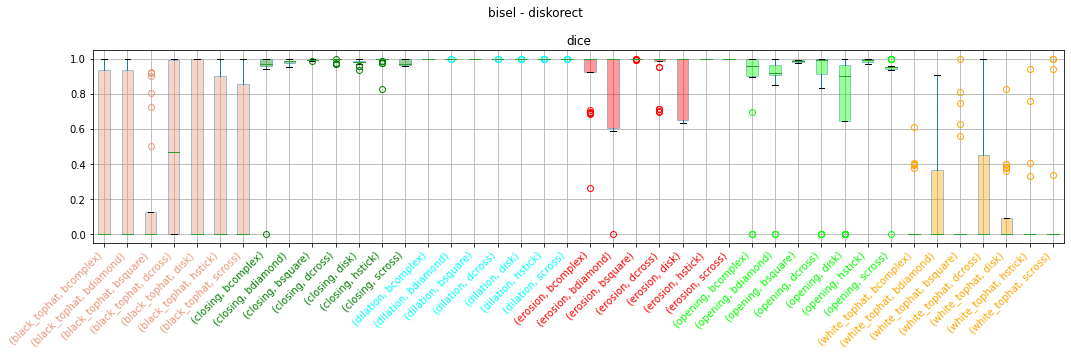

In [23]:
model = "bisel"
dataset = "diskorect"

cur_df = big_df[
    (big_df["atomic_element"] == model) & (big_df["dataset_type"] == dataset)
]

fig = draw_boxplot(
    cur_df, 
    title=f"{model} - {dataset}"
)
fig.tight_layout()
# plt.savefig("test.png", bbox_inches='tight')

In [20]:
import shutil
df = dfs['dual_bisel', 'mnist_gray']
# for tb_path in df[df["dice"] == -1].tb_path:
#     shutil.rmtree(tb_path)

In [18]:
df[df['dice'] == -1]

,args,tb_path,weights,normalized_weights,bias,dice,baseline_dice,binary_mode_dice,convergence_dice,activation_P,...,bias_optim_mode,loss_data_str,initializer_method,initializer_args,bise_init_method,optimizer,operations,loss_data,operation,selem
22,"{'experiment_name': 'Bimonn_exp_75/multi/0', '...",deep_morpho/results/results_tensorboards/Bimon...,None,{},None,-1.0,-1,-1.0,NaN,0,...,POSITIVE_INTERVAL_REPARAMETRIZED,MSELoss,INPUT_MEAN,None,CUSTOM_CONSTANT_DUAL_RANDOM_BIAS,Adam,None,MSELoss,opening_gray,bsquare
176,"{'experiment_name': 'Bimonn_exp_75/multi/0', '...",deep_morpho/results/results_tensorboards/Bimon...,None,{},None,-1.0,-1,-1.0,NaN,0,...,POSITIVE_INTERVAL_REPARAMETRIZED,BCELoss,INPUT_MEAN,None,CUSTOM_CONSTANT_DUAL_RANDOM_BIAS,Adam,None,BCELoss,erosion_gray,bsquare
340,"{'experiment_name': 'Bimonn_exp_75/multi/0', '...",deep_morpho/results/results_tensorboards/Bimon...,None,{},None,-1.0,-1,-1.0,NaN,0,...,POSITIVE_INTERVAL_PROJECTED,MSELoss,INPUT_MEAN,None,CUSTOM_CONSTANT_DUAL_RANDOM_BIAS,Adam,None,MSELoss,white_tophat_gray,dcross
423,"{'experiment_name': 'Bimonn_exp_75/multi/0', '...",deep_morpho/results/results_tensorboards/Bimon...,None,{},None,-1.0,-1,-1.0,NaN,0,...,POSITIVE_INTERVAL_REPARAMETRIZED,DiceLoss,INPUT_MEAN,None,CUSTOM_CONSTANT_DUAL_RANDOM_BIAS,Adam,None,DiceLoss,closing_gray,bcomplex
730,"{'experiment_name': 'Bimonn_exp_75/multi/0', '...",deep_morpho/results/results_tensorboards/Bimon...,None,{},None,-1.0,-1,-1.0,NaN,0,...,POSITIVE_INTERVAL_PROJECTED,BCELoss,INPUT_MEAN,None,CUSTOM_CONSTANT_DUAL_RANDOM_BIAS,Adam,None,BCELoss,black_tophat_gray,disk


In [22]:
import itertools
tuples = [t for t in itertools.product(range(1000), range(4))]
index = pd.MultiIndex.from_tuples(tuples, names=['lvl0', 'lvl1'])
data = np.random.randn(len(index),4)
df2 = pd.DataFrame(data, columns=list('ABCD'), index=index)

In [23]:
df2

A         B         C         D
lvl0 lvl1                                        
0    0     0.146845  0.696214 -0.489759  1.078833
     1    -0.206871 -0.409246 -0.962613  0.114661
     2    -1.051257  0.531811 -2.631786  1.177396
     3     1.100685 -0.474320  0.006299 -0.945244
1    0    -1.609972  0.566317 -0.015657  1.483003
...             ...       ...       ...       ...
998  3    -0.266061 -0.330491  0.334297 -1.150039
999  0     1.186518  0.013531 -0.527366  0.301825
     1    -0.557792 -1.757992  1.413919 -1.067555
     2    -0.646023  1.336598  1.586004 -0.834327
     3     0.042090 -1.412424 -0.761478  0.839833

[4000 rows x 4 columns]

In [6]:
tb_path = df[
    (df['learning_rate'] == '0.01') &
    (df['loss_data_str'] == 'MaskedDiceLoss') &
    (df['init_weight_mode'] == 'CUSTOM_CONSTANT') &
    (df['bias_optim_mode'] == 'POSITIVE_INTERVAL_REPARAMETRIZED') &
    (df['operation'] == 'dilation') & 
    (df['selem'] == 'disk')
].tb_path
# with open(join(tb_path, 'seed.txt'), 'r') as f:
#     s = f.read()
# s

In [14]:
tb_path.iloc[0]

'deep_morpho/results/results_tensorboards/Bimonn_mega_multi_1/softplus/diskorect/dilation/disk/version_50'

#### Binary Mode Success Number

In [7]:
changing = ["operation", "selem", ]
metrics = ['dice', 'binary_mode_dice']

df.groupby(changing)[metrics].mean()

dice  binary_mode_dice
operation    selem                             
black_tophat dcross  0.456932          0.486920
             disk    0.468572          0.482921
             hstick  0.339391          0.335720
closing      dcross  0.939893          0.901833
             disk    0.968185          0.867027
             hstick  0.975015          0.933311
dilation     dcross  0.997769          0.997736
             disk    0.996638          0.996191
             hstick  0.999956          1.000000
erosion      dcross  0.592276          0.613526
             disk    0.575092          0.620956
             hstick  0.705869          0.723463
opening      dcross  0.654607          0.640022
             disk    0.756457          0.626815
             hstick  0.940413          0.824720
white_tophat dcross  0.392134          0.456865
             disk    0.382384          0.372300
             hstick  0.221990          0.283608

In [8]:
pd.DataFrame(df.loc[df['binary_mode_dice'] == 1, ["operation", "selem"]].value_counts().sort_values()).sort_values(by=['operation', 'selem'])

0
operation    selem     
black_tophat dcross  14
             disk     9
             hstick   5
closing      dcross  29
             disk    14
             hstick  17
dilation     dcross  49
             disk    49
             hstick  53
erosion      dcross  27
             disk    19
             hstick  37
opening      dcross  14
             disk     4
             hstick  17
white_tophat dcross   1

In [23]:
display(pd.DataFrame(df.loc[(df['dice'] == 1) & (df['init_weight_mode'] == "CUSTOM_CONSTANT"), ["operation", "selem"]].value_counts().sort_values()).sort_values(by=['operation', 'selem']))
display(pd.DataFrame(df.loc[(df['dice'] == 1), ["operation", "selem"]].value_counts().sort_values()).sort_values(by=['operation', 'selem']))


0
operation    selem     
black_tophat dcross   6
             disk     3
             hstick   3
closing      dcross  11
             disk     1
             hstick   6
dilation     dcross  17
             disk    16
             hstick  15
erosion      dcross  10
             disk     8
             hstick  11
opening      dcross   2
             disk     1
             hstick   5
white_tophat dcross   1

0
operation    selem     
black_tophat dcross  18
             disk    11
             hstick   9
closing      dcross  25
             disk     9
             hstick  15
dilation     dcross  48
             disk    48
             hstick  49
erosion      dcross  17
             disk    16
             hstick  20
opening      dcross   3
             disk     3
             hstick  17
white_tophat dcross   2
             hstick   1

#### Best Set of hyperparameters

In [7]:
changing = [
    'loss_data_str',
    'bias_optim_mode',
    'learning_rate',
    'init_weight_mode'
]
metrics = ['dice', 'binary_mode_dice']

results = {}
sums = {}
sums_style = {}


for L in range(1, len(changing) + 1):
    for subset in itertools.combinations(changing, L):
        df_summary = df.pivot_table(index=subset, columns=['operation', 'selem'], values='binary_mode_dice', aggfunc=lambda x: (x==1).any())#.astype(int)
        sums[subset] = pd.DataFrame(df_summary.sum(axis=1) / len(df_summary.columns))
        sums_style[subset] = sums[subset].style.format("{:,.0%}".format)
        results[subset] = df_summary




In [26]:
len(df_summary.columns) * len(df_summary)

954

In [19]:
df_all = df.pivot_table(index=changing, columns=['operation', 'selem'], values=['binary_mode_dice', 'dice'], aggfunc='mean').rename(columns={'dcross': 'dc', 'disk': 'di', 'hstick': 'hs'})
df_all.style.background_gradient(cmap='RdBu', vmin=0, vmax=1).format('{:.2f}')


In [18]:
def color_results(val):
    if val == True:
        return f'color: green'
    elif val == False:
        return f'color: red'
    elif val is None:
        return f'color: blue'

def display_color(df):
    display(df.style.applymap(color_results))

# results[tuple(changing)].style.applymap(color_results)
display_color(results[tuple(changing)])
# display_color(results[("loss_data_str", "init_weight_mode")])

In [12]:
pd.DataFrame(results[tuple(changing)].sum(1) / len(results[tuple(changing)].columns)).style.format('{:.0%}')

# Bimonn Multi Sybisel

## Init no biased compl / op

In [3]:
def list_dir_joined(folder: str):
    return [os.path.join(folder, k) for k in os.listdir(folder)]

path_global = "/hdd/aouadt/these/projets/3d_segm/deep_morpho/results/results_tensorboards/Bimonn_exp_63/multi/sybisel/softplus/diskorect/"
all_paths = []
for operation in os.listdir(path_global):
    if os.path.isdir(join(path_global, operation)):
        for selem in os.listdir(join(path_global, operation)):
            # if selem == 'bdiamond':
            #     print(selem)
            all_paths += sorted(list_dir_joined(join(path_global, operation, selem)), key=lambda x: int(
                re.findall(r'version_(\d+)$', x)[0]
            ))[:-1]
print(len(all_paths))
    

258


In [4]:
reload_modules()
results = dr.DisplayResults().get_all_results_from_tensorboard(all_paths, load_long_args=False)

for r in results:
    r.update(r['args'])

Reading results: 100%|██████████| 258/258 [00:11<00:00, 22.33it/s]


In [5]:
df = pd.DataFrame(results)
df['dice'] = df['dice'].astype(float)
df['binary_mode_dice'] = df['binary_mode_dice'].astype(float)
df['operation'] = df['experiment_subname'].apply(lambda x: pathlib.Path(x).parent.stem)
df['selem'] = df['experiment_subname'].apply(lambda x: pathlib.Path(x).stem)

In [40]:
df[
    (df['learning_rate'] == '0.01') &
    (df['loss_data_str'] == 'NormalizedDiceLoss') 
    # (df['init_weight_mode'] == 'CUSTOM_CONSTANT') &
    # (df['bias_optim_mode'] == 'POSITIVE_INTERVAL_REPARAMETRIZED') &
    # (df['operation'] == 'opening') & 
    # (df['selem'] == 'hstick')
]
# with open(join(tb_path, 'seed.txt'), 'r') as f:
#     s = f.read()
# s

,args,tb_path,weights,normalized_weights,bias,dice,baseline_dice,binary_mode_dice,convergence_dice,activation_P,...,bias_optim_mode,loss_data_str,initializer_method,initializer_args,bise_init_method,optimizer,operations,loss_data,operation,selem


#### Binary Mode Success Number

In [7]:
changing = ["operation", "selem", ]
metrics = ['dice', 'binary_mode_dice']

df.groupby(changing)[metrics].mean()

dice  binary_mode_dice
operation    selem                               
black_tophat dcross    0.787829          0.584358
             disk      0.576229          0.469763
             hstick    0.800023          0.611364
closing      dcross    0.950397          0.923316
             disk      0.950629          0.887416
             hstick    0.982025          0.923033
dilation     bcomplex  0.998241          1.000000
             bdiamond  0.996488          1.000000
             bsquare   0.999659          1.000000
             dcross    0.998746          0.998757
             disk      0.992764          0.998750
             hstick    0.997077          1.000000
erosion      bcomplex  0.986657          1.000000
             bdiamond  0.978992          1.000000
             bsquare   0.999172          1.000000
             dcross    0.991217          0.987679
             disk      0.947644          0.980095
             hstick    0.992179          1.000000
opening      dcross    0.922787          0.850248
             disk      0.856041          0.695845
             hstick    0.966279          0.851179
white_tophat dcross    0.756640          0.591512
             disk      0.925504          0.541840
             hstick    0.761893          0.581860

In [9]:
type(pd.DataFrame(df.loc[df['dice'] > 0.99, ["operation", "selem"]].value_counts().sort_values()).sort_values(by=['operation', 'selem']).to_html())

str

In [6]:
print("Binary")
display(pd.DataFrame(df.loc[df['binary_mode_dice'] == 1, ["operation", "selem"]].value_counts().sort_values()).sort_values(by=['operation', 'selem']))

print("Real")
display(pd.DataFrame(df.loc[df['dice'] > 0.99, ["operation", "selem"]].value_counts().sort_values()).sort_values(by=['operation', 'selem']))


Binary


0
operation    selem       
black_tophat disk       1
             hstick     1
closing      dcross     1
dilation     bcomplex   5
             bdiamond   5
             bsquare    5
             dcross    11
             disk       7
             hstick     9
             scross     5
erosion      bcomplex   5
             bdiamond   5
             bsquare    5
             dcross    11
             disk       7
             hstick     9
             scross     5
opening      dcross     1
white_tophat bcomplex   1
             bdiamond   1
             hstick     1

Real


0
operation    selem       
black_tophat bcomplex   1
             disk       2
             hstick     3
closing      bsquare    5
             dcross     2
             hstick     1
dilation     bcomplex   5
             bdiamond   4
             bsquare    5
             dcross    13
             disk       5
             hstick     7
             scross     5
erosion      bcomplex   3
             bdiamond   4
             bsquare    5
             dcross     9
             disk       3
             hstick     6
             scross     4
opening      bsquare    4
             dcross     2
             disk       1
white_tophat bcomplex   1
             bdiamond   1
             disk       6
             hstick     1
             scross     1

#### Best Set of hyperparameters

In [11]:
changing = [
    'loss_data_str',
    'learning_rate',
    'bise_init_method'
]
metrics = ['dice', 'binary_mode_dice']

results = {}
sums = {}
sums_style = {}


for L in range(1, len(changing) + 1):
    for subset in itertools.combinations(changing, L):
        df_summary = df.pivot_table(index=subset, columns=['operation', 'selem'], values='binary_mode_dice', aggfunc=lambda x: (x==1).any())#.astype(int)
        sums[subset] = pd.DataFrame(df_summary.sum(axis=1) / len(df_summary.columns))
        sums_style[subset] = sums[subset].style.format("{:,.0%}".format)
        results[subset] = df_summary




In [8]:
len(df_summary.columns) * len(df_summary)

374

In [20]:
pd.__version__

'1.2.4'

In [19]:
df_all.style.background_gradient(cmap='RdBu', vmin=0, vmax=1).format('{:.2f}')

In [12]:
new_cols = {'dcross': 'dc', 'disk': 'di', 'hstick': 'hs', 'bcomplex': 'bc', 'bdiamond': 'bd', 'bsquare': 'bs'}

print('Binary')
df_all = df.pivot_table(index=changing, columns=['operation', 'selem'], values=['binary_mode_dice'], aggfunc='mean').rename(columns=new_cols)
display(df_all.style.background_gradient(cmap='RdBu', vmin=0, vmax=1).format('{:.2f}'))

print('Real')
df_all = df.pivot_table(index=changing, columns=['operation', 'selem'], values=['dice'], aggfunc='mean').rename(columns=new_cols)
display(df_all.style.background_gradient(cmap='RdBu', vmin=0, vmax=1).format('{:.2f}'))

Binary


Real


In [31]:
df[
    (df['operation'] == "closing") & 
    (df['selem'] == "dcross") & 
    (df['bise_init_method'] == "CUSTOM_CONSTANT_RANDOM_BIAS") &
    (df['learning_rate'] == "0.01") &
    (df['loss_data_str'] == "MaskedMSELoss")
].tb_path.iloc[0]

'/hdd/aouadt/these/projets/3d_segm/deep_morpho/results/results_tensorboards/Bimonn_exp_63/multi/sybisel/softplus/diskorect/closing/dcross/version_3'

In [ ]:
def color_results(val):
    if val == True:
        return f'color: green'
    elif val == False:
        return f'color: red'
    elif val is None:
        return f'color: blue'

def display_color(df):
    display(df.style.applymap(color_results))

# results[tuple(changing)].style.applymap(color_results)
display_color(results[tuple(changing)])
# display_color(results[("loss_data_str", "init_weight_mode")])

In [ ]:
pd.DataFrame(results[tuple(changing)].sum(1) / len(results[tuple(changing)].columns)).style.format('{:.0%}')

## Init complementary init - no bias op

In [4]:
def list_dir_joined(folder: str):
    return [os.path.join(folder, k) for k in os.listdir(folder)]

path_global = "/hdd/aouadt/these/projets/3d_segm/deep_morpho/results/results_tensorboards/Bimonn_exp_67/sandbox/sybisel/softplus/diskorect/"
all_paths = []
for operation in os.listdir(path_global):
    if os.path.isdir(join(path_global, operation)):
        for selem in os.listdir(join(path_global, operation)):
            # if selem == 'bdiamond':
            #     print(selem)
            all_paths += sorted(list_dir_joined(join(path_global, operation, selem)), key=lambda x: int(
                re.findall(r'version_(\d+)$', x)[0]
            ))[:-1]
print(len(all_paths))
    

98


In [5]:
reload_modules()
results = dr.DisplayResults().get_all_results_from_tensorboard(all_paths, load_long_args=False)

for r in results:
    r.update(r['args'])

Reading results: 100%|██████████| 98/98 [00:00<00:00, 185.16it/s]


In [6]:
df = pd.DataFrame(results)
df['dice'] = df['dice'].astype(float)
df['binary_mode_dice'] = df['binary_mode_dice'].astype(float)
df['operation'] = df['experiment_subname'].apply(lambda x: pathlib.Path(x).parent.stem)
df['selem'] = df['experiment_subname'].apply(lambda x: pathlib.Path(x).stem)

In [7]:
df[
    (df['learning_rate'] == '0.01') &
    (df['loss_data_str'] == 'NormalizedDiceLoss') 
    # (df['init_weight_mode'] == 'CUSTOM_CONSTANT') &
    # (df['bias_optim_mode'] == 'POSITIVE_INTERVAL_REPARAMETRIZED') &
    # (df['operation'] == 'opening') & 
    # (df['selem'] == 'hstick')
]
# with open(join(tb_path, 'seed.txt'), 'r') as f:
#     s = f.read()
# s

,args,tb_path,weights,normalized_weights,bias,dice,baseline_dice,binary_mode_dice,convergence_dice,activation_P,...,bias_optim_mode,loss_data_str,initializer_method,initializer_args,bise_init_method,optimizer,operations,loss_data,operation,selem


#### Binary Mode Success Number

In [8]:
changing = ["operation", "selem", ]
metrics = ['dice', 'binary_mode_dice']

df.groupby(changing)[metrics].mean()

dice  binary_mode_dice
operation selem                               
closing   bcomplex  0.926048          0.894245
          bdiamond  0.954334          0.871816
          bsquare   0.984638          0.910939
          dcross    0.984170          0.969534
          disk      0.951960          0.863006
          hstick    0.956058          0.906043
          scross    0.969367          0.871957
opening   bcomplex  0.896390          0.678373
          bdiamond  0.912138          0.648424
          bsquare   0.982415          0.919040
          dcross    0.787839          0.741503
          disk      0.898224          0.649952
          hstick    0.941305          0.828182
          scross    0.935326          0.683361

In [9]:
print("Binary")
display(pd.DataFrame(df.loc[df['binary_mode_dice'] == 1, ["operation", "selem"]].value_counts().sort_values()).sort_values(by=['operation', 'selem']))

print("Real")
display(pd.DataFrame(df.loc[df['dice'] > 0.99, ["operation", "selem"]].value_counts().sort_values()).sort_values(by=['operation', 'selem']))


Binary


,,0
operation,selem,
closing,dcross,5
opening,dcross,3


Real


0
operation selem      
closing   bcomplex  1
          bsquare   2
          dcross    5
opening   bsquare   2
          dcross    3

#### Best Set of hyperparameters

In [10]:
changing = [
    'loss_data_str',
    'learning_rate',
    'bise_init_method'
]
metrics = ['dice', 'binary_mode_dice']

results = {}
sums = {}
sums_style = {}


for L in range(1, len(changing) + 1):
    for subset in itertools.combinations(changing, L):
        df_summary = df.pivot_table(index=subset, columns=['operation', 'selem'], values='binary_mode_dice', aggfunc=lambda x: (x==1).any())#.astype(int)
        sums[subset] = pd.DataFrame(df_summary.sum(axis=1) / len(df_summary.columns))
        sums_style[subset] = sums[subset].style.format("{:,.0%}".format)
        results[subset] = df_summary




In [11]:
len(df_summary.columns) * len(df_summary)

56

In [12]:
new_cols = {'dcross': 'dc', 'disk': 'di', 'hstick': 'hs', 'bcomplex': 'bc', 'bdiamond': 'bd', 'bsquare': 'bs'}

print('Binary')
df_all = df.pivot_table(index=changing, columns=['operation', 'selem'], values=['binary_mode_dice'], aggfunc='mean').rename(columns=new_cols)
display(df_all.style.background_gradient(cmap='RdBu', vmin=0, vmax=1).format('{:.2f}'))

print('Real')
df_all = df.pivot_table(index=changing, columns=['operation', 'selem'], values=['dice'], aggfunc='mean').rename(columns=new_cols)
display(df_all.style.background_gradient(cmap='RdBu', vmin=0, vmax=1).format('{:.2f}'))

Binary


Real


In [ ]:
df[
    (df['operation'] == "closing") & 
    (df['selem'] == "dcross") & 
    (df['bise_init_method'] == "CUSTOM_CONSTANT_RANDOM_BIAS") &
    (df['learning_rate'] == "0.01") &
    (df['loss_data_str'] == "MaskedMSELoss")
].tb_path.iloc[0]

'/hdd/aouadt/these/projets/3d_segm/deep_morpho/results/results_tensorboards/Bimonn_exp_63/multi/sybisel/softplus/diskorect/closing/dcross/version_3'

In [13]:
def color_results(val):
    if val == True:
        return f'color: green'
    elif val == False:
        return f'color: red'
    elif val is None:
        return f'color: blue'

def display_color(df):
    display(df.style.applymap(color_results))

# results[tuple(changing)].style.applymap(color_results)
display_color(results[tuple(changing)])
# display_color(results[("loss_data_str", "init_weight_mode")])

In [14]:
pd.DataFrame(results[tuple(changing)].sum(1) / len(results[tuple(changing)].columns)).style.format('{:.0%}')

## Init compl / op biased

In [16]:
def list_dir_joined(folder: str):
    return [os.path.join(folder, k) for k in os.listdir(folder)]

path_global = "/hdd/aouadt/these/projets/3d_segm/deep_morpho/results/results_tensorboards/Bimonn_exp_66/sandbox/sybisel/softplus/diskorect/"
all_paths = []
for operation in os.listdir(path_global):
    if os.path.isdir(join(path_global, operation)):
        for selem in os.listdir(join(path_global, operation)):
            # if selem == 'bdiamond':
            #     print(selem)
            all_paths += sorted(list_dir_joined(join(path_global, operation, selem)), key=lambda x: int(
                re.findall(r'version_(\d+)$', x)[0]
            ))[:-1]
print(len(all_paths))
    

14


In [17]:
reload_modules()
results = dr.DisplayResults().get_all_results_from_tensorboard(all_paths, load_long_args=False)

for r in results:
    r.update(r['args'])

Reading results: 100%|██████████| 14/14 [00:00<00:00, 183.03it/s]


In [18]:
df = pd.DataFrame(results)
df['dice'] = df['dice'].astype(float)
df['binary_mode_dice'] = df['binary_mode_dice'].astype(float)
df['operation'] = df['experiment_subname'].apply(lambda x: pathlib.Path(x).parent.stem)
df['selem'] = df['experiment_subname'].apply(lambda x: pathlib.Path(x).stem)

In [19]:
df[
    (df['learning_rate'] == '0.01') &
    (df['loss_data_str'] == 'NormalizedDiceLoss') 
    # (df['init_weight_mode'] == 'CUSTOM_CONSTANT') &
    # (df['bias_optim_mode'] == 'POSITIVE_INTERVAL_REPARAMETRIZED') &
    # (df['operation'] == 'opening') & 
    # (df['selem'] == 'hstick')
]
# with open(join(tb_path, 'seed.txt'), 'r') as f:
#     s = f.read()
# s

,args,tb_path,weights,normalized_weights,bias,dice,baseline_dice,binary_mode_dice,convergence_dice,activation_P,...,bias_optim_mode,loss_data_str,initializer_method,initializer_args,bise_init_method,optimizer,operations,loss_data,operation,selem


#### Binary Mode Success Number

In [20]:
changing = ["operation", "selem", ]
metrics = ['dice', 'binary_mode_dice']

df.groupby(changing)[metrics].mean()

dice  binary_mode_dice
operation selem                               
closing   bcomplex  1.000000          1.000000
          bdiamond  0.986224          0.960770
          bsquare   1.000000          1.000000
          dcross    1.000000          1.000000
          disk      0.992416          0.991474
          hstick    0.998667          0.979673
          scross    0.971605          0.863744
opening   bcomplex  1.000000          1.000000
          bdiamond  0.949505          0.898347
          bsquare   0.992403          0.969048
          dcross    1.000000          1.000000
          disk      0.985815          0.984588
          hstick    0.987941          0.967982
          scross    0.946279          0.854218

In [21]:
print("Binary")
display(pd.DataFrame(df.loc[df['binary_mode_dice'] == 1, ["operation", "selem"]].value_counts().sort_values()).sort_values(by=['operation', 'selem']))

print("Real")
display(pd.DataFrame(df.loc[df['dice'] > 0.99, ["operation", "selem"]].value_counts().sort_values()).sort_values(by=['operation', 'selem']))


Binary


0
operation selem      
closing   bcomplex  1
          bsquare   1
          dcross    1
opening   bcomplex  1
          dcross    1

Real


0
operation selem      
closing   bcomplex  1
          bsquare   1
          dcross    1
          disk      1
          hstick    1
opening   bcomplex  1
          bsquare   1
          dcross    1

#### Best Set of hyperparameters

In [22]:
changing = [
    'loss_data_str',
    'learning_rate',
    'bise_init_method'
]
metrics = ['dice', 'binary_mode_dice']

results = {}
sums = {}
sums_style = {}


for L in range(1, len(changing) + 1):
    for subset in itertools.combinations(changing, L):
        df_summary = df.pivot_table(index=subset, columns=['operation', 'selem'], values='binary_mode_dice', aggfunc=lambda x: (x==1).any())#.astype(int)
        sums[subset] = pd.DataFrame(df_summary.sum(axis=1) / len(df_summary.columns))
        sums_style[subset] = sums[subset].style.format("{:,.0%}".format)
        results[subset] = df_summary




In [23]:
len(df_summary.columns) * len(df_summary)

14

In [24]:
new_cols = {'dcross': 'dc', 'disk': 'di', 'hstick': 'hs', 'bcomplex': 'bc', 'bdiamond': 'bd', 'bsquare': 'bs'}

print('Binary')
df_all = df.pivot_table(index=changing, columns=['operation', 'selem'], values=['binary_mode_dice'], aggfunc='mean').rename(columns=new_cols)
display(df_all.style.background_gradient(cmap='RdBu', vmin=0, vmax=1).format('{:.2f}'))

print('Real')
df_all = df.pivot_table(index=changing, columns=['operation', 'selem'], values=['dice'], aggfunc='mean').rename(columns=new_cols)
display(df_all.style.background_gradient(cmap='RdBu', vmin=0, vmax=1).format('{:.2f}'))

Binary


Real


In [26]:
def color_results(val):
    if val == True:
        return f'color: green'
    elif val == False:
        return f'color: red'
    elif val is None:
        return f'color: blue'

def display_color(df):
    display(df.style.applymap(color_results))

# results[tuple(changing)].style.applymap(color_results)
display_color(results[tuple(changing)])
# display_color(results[("loss_data_str", "init_weight_mode")])

In [27]:
pd.DataFrame(results[tuple(changing)].sum(1) / len(results[tuple(changing)].columns)).style.format('{:.0%}')

,,,0
loss_data_str,learning_rate,bise_init_method,
MSELoss,0.01,CUSTOM_CONSTANT,36%
